In [1]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('../..'))))

import torch
import numpy as np
from models.Feature.GooLeNet import GoogLeNet

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = 'cpu'
    torch.set_default_tensor_type('torch.FloatTensor')

In [3]:
class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
model = GoogLeNet(classes=len(class_name)).to(device)

In [5]:
model.load_state_dict(torch.load('inception_v1_cifar10_model.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [6]:
feature_blobs = []

In [7]:
def hook_feature(module, input, output):
    feature_blobs.append(output.cpu().data.numpy())

In [8]:
model._modules

OrderedDict([('pre_layers', Sequential(
                (0): Conv2d(3, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): ReLU(inplace)
              )), ('a3', Inceptionv1(
                (branch1): Sequential(
                  (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
                  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (2): ReLU(inplace)
                )
                (branch2): Sequential(
                  (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
                  (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (2): ReLU(inplace)
                  (3): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_

In [9]:
model._modules.get('b5').register_forward_hook(hook_feature)

In [10]:
params = list(model.parameters())

In [11]:
class_weights = np.squeeze(params[-2].cpu().data.numpy())

In [12]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = './test4.png'

img = Image.open(img_path)

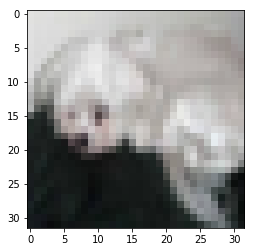

In [13]:
plt.imshow(img)

In [14]:
import torchvision.transforms as transforms

cvt_tensor = transforms.ToTensor()

tensor_img = cvt_tensor(img).to(device)

In [15]:
tensor_img = tensor_img.view(1, 3, 32, 32)

In [16]:
output = model(tensor_img)

In [17]:
from torch.nn import functional as F

h_x = F.softmax(output, dim=1).data.squeeze()

In [18]:
h_x.sort(0, True)

torch.return_types.sort(
values=tensor([5.9461e-01, 4.0404e-01, 7.8578e-04, 2.6229e-04, 2.3669e-04, 4.3063e-05,
        1.0726e-05, 3.6676e-06, 1.6180e-07, 1.5821e-07]),
indices=tensor([5, 3, 9, 6, 2, 1, 8, 0, 4, 7]))

In [19]:
pred = h_x.argmax(0).item()
print(pred)

5


In [20]:
class_name[pred]

'dog'

In [21]:
feature_blobs[0][0].shape

(1024, 8, 8)

In [22]:
class_weights.shape

(10, 1024)

In [23]:
final_conv = feature_blobs[0][0]

In [24]:
cam = np.zeros(dtype=np.float32, shape=final_conv.shape[1:3])

for i, w in enumerate(class_weights[pred]):
    cam += w*final_conv[i,:,:]

In [25]:
print(cam)

[[  1.0455099    4.5416355   -0.13459587  -8.841551    -6.7618256
   -9.154972    -1.4798237   -0.48359084]
 [-41.23369      0.33520317  -3.2059374  -27.363903   -44.015015
   -9.411132   -11.552276   -13.492553  ]
 [-24.042303     7.042859    36.980034     7.8405905  -42.933987
  -51.32384     -2.534158   -22.854473  ]
 [-29.6921      -4.021414    99.80512     89.13941    -28.04153
  -47.639797     4.543765   -13.653124  ]
 [ -1.4144233   -5.8650846  -33.823013   -63.04322    -68.33725
  -40.58132    -38.437275   -26.129597  ]
 [ 11.192335    -6.524714   -86.70717    -67.70184     -2.4941509
    2.2065554  -32.57791    -42.60388   ]
 [ -9.421419    -4.3986616  -28.160873   -28.626972    12.47725
  -17.122759   -94.32389    -25.947517  ]
 [-24.488794   -37.24051     -2.6886332    5.1673293    6.999529
  -10.15992    -40.609993   -58.431423  ]]


In [26]:
cam = cam - np.min(cam)

In [27]:
cam /= np.max(cam)

In [28]:
cam

array([[0.49126816, 0.5092774 , 0.48518917, 0.44033778, 0.4510509 ,
        0.43872327, 0.47825962, 0.48339143],
       [0.27347896, 0.4876092 , 0.469368  , 0.34492522, 0.25915176,
        0.43740374, 0.42637426, 0.41637948],
       [0.36203545, 0.5221618 , 0.67637455, 0.52627105, 0.26472038,
        0.22150244, 0.4728285 , 0.36815426],
       [0.33293214, 0.46516734, 1.        , 0.94505864, 0.3414346 ,
        0.24047974, 0.5092884 , 0.41555235],
       [0.4785965 , 0.4556702 , 0.31165293, 0.16113341, 0.13386273,
        0.27683944, 0.28788388, 0.35128334],
       [0.5435366 , 0.45227233, 0.03923536, 0.13713585, 0.47303462,
        0.49724895, 0.31806672, 0.2664208 ],
       [0.43735078, 0.46322408, 0.34081984, 0.33841884, 0.55015546,
        0.39767954, 0.        , 0.3522213 ],
       [0.3597355 , 0.2940487 , 0.47203276, 0.5125005 , 0.52193856,
        0.43354657, 0.27669176, 0.18488976]], dtype=float32)

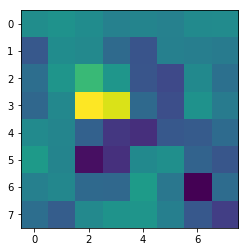

In [29]:
plt.imshow(cam)

In [30]:
import cv2

cam = cv2.resize(cam, (128, 128))

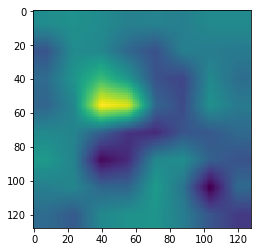

In [31]:
plt.imshow(cam)

In [32]:
heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)

In [33]:
img = cv2.imread(img_path)
img = cv2.resize(img, (128,128))

In [34]:
img.shape

(128, 128, 3)

In [35]:
heatimg = heatmap*0.3 + img*0.5

In [36]:
cv2.imwrite('./cam.jpg', heatimg)

True

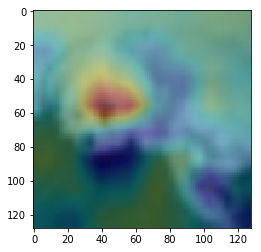

In [37]:
cam_img = cv2.imread('./cam.jpg')
cam_img = cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGB)
plt.imshow(cam_img)

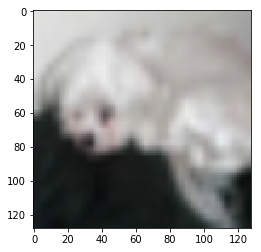

In [38]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))